# 과적합 해결

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [3]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.79MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [5]:
# 데이터 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # (배치크기, h, w) -> (배치크기, 특성)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [7]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [8]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print('\n배치 정규화 적용')
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2531, Accuracy: 0.9267
Epoch 2 | Val Loss: 0.1900, Accuracy: 0.9428
Epoch 3 | Val Loss: 0.1517, Accuracy: 0.9545
Epoch 4 | Val Loss: 0.1276, Accuracy: 0.9613
Epoch 5 | Val Loss: 0.1174, Accuracy: 0.9651

배치 정규화 적용
Epoch 1 | Val Loss: 0.1370, Accuracy: 0.9579
Epoch 2 | Val Loss: 0.1057, Accuracy: 0.9667
Epoch 3 | Val Loss: 0.0912, Accuracy: 0.9715
Epoch 4 | Val Loss: 0.0946, Accuracy: 0.9697
Epoch 5 | Val Loss: 0.0853, Accuracy: 0.9739


In [9]:
for batch_size in [16, 32, 128]:
    print(f'batch size: {batch_size}')
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1209, Accuracy: 0.9639
Epoch 2 | Val Loss: 0.0943, Accuracy: 0.9730
Epoch 3 | Val Loss: 0.0875, Accuracy: 0.9741
Epoch 4 | Val Loss: 0.0926, Accuracy: 0.9737
Epoch 5 | Val Loss: 0.0791, Accuracy: 0.9768
batch size: 32
Epoch 1 | Val Loss: 0.1196, Accuracy: 0.9640
Epoch 2 | Val Loss: 0.0928, Accuracy: 0.9698
Epoch 3 | Val Loss: 0.0826, Accuracy: 0.9732


KeyboardInterrupt: 

### 드롭아웃 적용

In [10]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [11]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2576, Accuracy: 0.9202


KeyboardInterrupt: 

- 훈련 시 드롭아웃 활성화, 테스트 시 비활성화

In [12]:
def train_do(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [13]:
model = DropoutNN(dropout_rate=0.3)

# train 모드 == 드롭아웃 활성화
model.train()
train_do(model, train_loader, val_loader)

print()

# eval 모드 == 드롭아웃 비활성화
model.eval()
train_do(model, train_loader, val_loader)

Epoch 1 | Val Loss: 0.4189, Accuracy: 0.8719
Epoch 2 | Val Loss: 0.3257, Accuracy: 0.9029
Epoch 3 | Val Loss: 0.2830, Accuracy: 0.9157


KeyboardInterrupt: 

### Learning Rate Schduler 적용

In [14]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        scheduler.step()
        print(f'epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}, LearningRate: {scheduler.get_last_lr()[0]}')

In [16]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

epoch 1 | Val Loss: 0.3031, Accuracy: 0.9096, LearningRate: 0.01
epoch 2 | Val Loss: 0.2497, Accuracy: 0.9269, LearningRate: 0.01
epoch 3 | Val Loss: 0.2195, Accuracy: 0.9357, LearningRate: 0.001
epoch 4 | Val Loss: 0.1502, Accuracy: 0.9576, LearningRate: 0.001
epoch 5 | Val Loss: 0.1410, Accuracy: 0.9594, LearningRate: 0.001
epoch 6 | Val Loss: 0.1423, Accuracy: 0.9587, LearningRate: 0.0001
epoch 7 | Val Loss: 0.1354, Accuracy: 0.9612, LearningRate: 0.0001
epoch 8 | Val Loss: 0.1349, Accuracy: 0.9618, LearningRate: 0.0001
epoch 9 | Val Loss: 0.1342, Accuracy: 0.9621, LearningRate: 1e-05
epoch 10 | Val Loss: 0.1340, Accuracy: 0.9626, LearningRate: 1e-05


### 조기종료 적용

In [29]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        # accuracy = correct / len(val_data)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기종료 epoch {epoch + 1}')
            break
    
    return train_losses, val_losses

In [30]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [32]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)


Epoch 1 | Loss: 0.2735, Accuracy: 0.9190
Epoch 2 | Loss: 0.2427, Accuracy: 0.9326
Epoch 3 | Loss: 0.2457, Accuracy: 0.9326
Epoch 4 | Loss: 0.1947, Accuracy: 0.9460
Epoch 5 | Loss: 0.1948, Accuracy: 0.9465
Epoch 6 | Loss: 0.2046, Accuracy: 0.9473
Epoch 7 | Loss: 0.2285, Accuracy: 0.9410
Epoch 8 | Loss: 0.2038, Accuracy: 0.9484
Epoch 9 | Loss: 0.2133, Accuracy: 0.9430
Epoch 10 | Loss: 0.2393, Accuracy: 0.9436
Epoch 11 | Loss: 0.2208, Accuracy: 0.9457
Epoch 12 | Loss: 0.2378, Accuracy: 0.9427
Epoch 13 | Loss: 0.2235, Accuracy: 0.9462
Epoch 14 | Loss: 0.2253, Accuracy: 0.9476
Epoch 15 | Loss: 0.2079, Accuracy: 0.9490
Epoch 16 | Loss: 0.2038, Accuracy: 0.9547
Epoch 17 | Loss: 0.1883, Accuracy: 0.9533
Epoch 18 | Loss: 0.2421, Accuracy: 0.9470
Epoch 19 | Loss: 0.2214, Accuracy: 0.9540
Epoch 20 | Loss: 0.1875, Accuracy: 0.9560
Epoch 21 | Loss: 0.2397, Accuracy: 0.9476
Epoch 22 | Loss: 0.2390, Accuracy: 0.9525
Epoch 23 | Loss: 0.2163, Accuracy: 0.9532
Epoch 24 | Loss: 0.2168, Accuracy: 0.9541
E

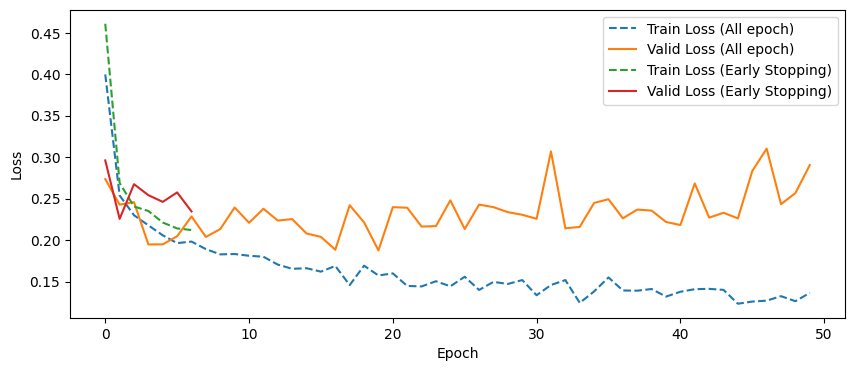

In [ ]:
import matplotlib.pyplot as plt

# train_loss보다 validation loss가 더 떨어지지 않음? 뭔지 하나도 모르겟다ㅠ 공부해야지...ㅠ
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### L1, L2 적용

- weight decay
    - 신경망의 가중치 값이 너무 커지면 특정 뉴런에 대한 의존성이 증가하여 과적합이 발생할 수 있다. 이를 방지하기 위해 L1 정규화(Lasso), L2 정규화(Ridge) 기법을 사용하여 손실 함수에 패널티를 추가한다.

In [39]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    weight_norms = []

    for epoch in range(epochs):
        # 시각화 시 활용 가능 #
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()            # 가중치 업데이트
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        ###########################

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():       # 비활성화?
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)        # 이미지와 라벨을 꺼내서 1차원으로 만들어줌
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)                   
                correct += (preds == labels).sum().item()       # 실제 예측과 맞는지 평가해서 계산

        val_loss /= len(val_loader)                              
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
        weight_norm = sum(torch.norm(p).item() for p in model.parameters())     # 가중치를 합산해준 것
        weight_norms.append(weight_norm)        # 합산한 가중치를 빈 리스트에 append

    return train_losses, val_losses, weight_norms

In [41]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)    # momentum: 얼만큼 빠르게 학습을 할지 속도를 지정해주는 것
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)         # weight_decay: 0.0은 규제를 안준거고 0.01로 규제를 주면서 과대적합되지 않게 함
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

epoch 1 | Train Loss: 0.4650, Val Loss: 0.2278, Accuracy: 0.9326
epoch 2 | Train Loss: 0.1988, Val Loss: 0.1760, Accuracy: 0.9462
epoch 3 | Train Loss: 0.1432, Val Loss: 0.1462, Accuracy: 0.9543
epoch 4 | Train Loss: 0.1161, Val Loss: 0.1274, Accuracy: 0.9595
epoch 5 | Train Loss: 0.0966, Val Loss: 0.1321, Accuracy: 0.9597
epoch 6 | Train Loss: 0.0843, Val Loss: 0.1022, Accuracy: 0.9692
epoch 7 | Train Loss: 0.0706, Val Loss: 0.1181, Accuracy: 0.9647
epoch 8 | Train Loss: 0.0633, Val Loss: 0.0950, Accuracy: 0.9719
epoch 9 | Train Loss: 0.0556, Val Loss: 0.0846, Accuracy: 0.9728
epoch 10 | Train Loss: 0.0494, Val Loss: 0.1038, Accuracy: 0.9696
epoch 1 | Train Loss: 0.5104, Val Loss: 0.3246, Accuracy: 0.9033
epoch 2 | Train Loss: 0.2735, Val Loss: 0.2809, Accuracy: 0.9172
epoch 3 | Train Loss: 0.2349, Val Loss: 0.2365, Accuracy: 0.9329
epoch 4 | Train Loss: 0.2208, Val Loss: 0.2144, Accuracy: 0.9413
epoch 5 | Train Loss: 0.2084, Val Loss: 0.1930, Accuracy: 0.9474
epoch 6 | Train Loss: 0.

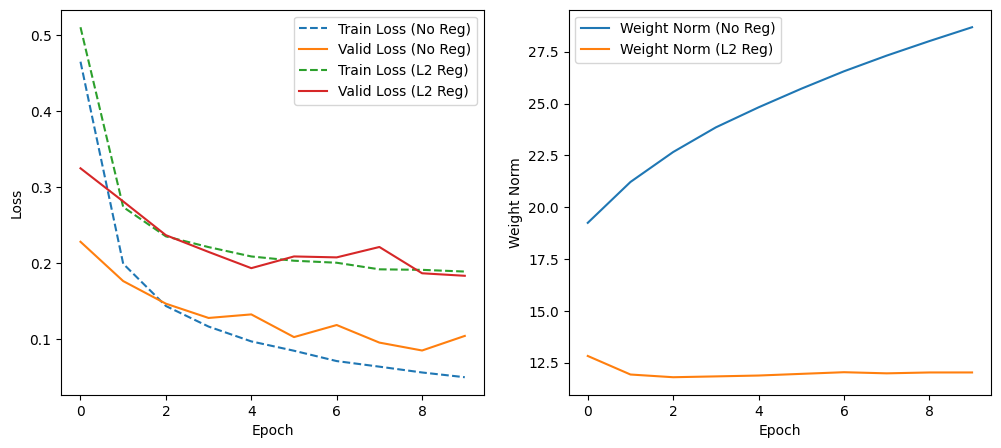

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)      # 1행, 2열로 나누고 그 중 첫 번째에 그림
plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Reg)')
plt.plot(train_reg_losses, label='Train Loss (L2 Reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Valid Loss (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(weight_norms, label='Weight Norm (No Reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()
# 딥러닝의 최적 모델 학습을 위한 과대적합 해결 내용